# Neon Cell Towers over the Grand Canyon

This notebook demonstrates loading GLB models and placing them on **real terrain data** from the USGS, rendered with eye-catching **neon colors** using rtxpy's GPU ray tracing engine.

**What you'll learn:**
1. Downloading real elevation data from USGS 3DEP
2. Loading GLB/glTF mesh files with `load_glb()`
3. Placing 3D models on terrain with `make_transforms_on_terrain()`
4. GPU-accelerated perspective rendering with custom shading

**Visual Style:**
- **Terrain**: Desert canyon colors (red/orange to tan)
- **Cell Towers**: Neon Magenta
- **Houses**: Neon Cyan

## 1. Setup and Imports

In [1]:
import numpy as np
import cupy as cp
from pathlib import Path
import matplotlib.pyplot as plt
import xarray as xr

# Import rtxpy - uses xarray accessor pattern
import rtxpy

print(f"rtxpy version: {rtxpy.__version__}")
print(f"GPU: {rtxpy.list_devices()}")

rtxpy version: 0.0.5
GPU: [{'name': 'NVIDIA RTX A6000', 'compute_capability': (8, 6), 'total_memory': 51526500352, 'multiprocessor_count': 84, 'id': 0}]


In [2]:
# (dimensions computed after DEM is loaded)

## 2. 3D Models

We'll place 3D models from the `models/` directory onto the terrain:
- **Broadcast Tower** - A detailed cell/broadcast tower model
- **American House** - A house model to populate our terrain
- **Pine Tree** - Trees to create forest groves

The `dem.rtx.place_mesh()` accessor loads mesh files (GLB, glTF, OBJ, STL, PLY, etc.) and places instances on the terrain in one step.

In [3]:
# Model paths
MODELS_DIR = Path.cwd() / "models"
TOWER_PATH = MODELS_DIR / "broadcast_tower_game_ready.glb"
HOUSE_PATH = MODELS_DIR / "american_house.glb"
TREE_PATH = MODELS_DIR / "pine_tree.glb"

# Target heights for models (meters)
# Original model heights are normalized by place_mesh using base_at_zero=True
TOWER_HEIGHT = 45   # Realistic cell tower: 30-60m
HOUSE_HEIGHT = 9    # Realistic 2-story house: ~8-10m
TREE_HEIGHT = 20    # Pine trees: 15-25m

print(f"Models directory: {MODELS_DIR}")
for name, path in [('Tower', TOWER_PATH), ('House', HOUSE_PATH), ('Tree', TREE_PATH)]:
    status = 'exists' if path.exists() else 'NOT FOUND'
    print(f"  {name}: {path.name} ({status})")

Models directory: /home/brendan/rtxpy/examples/models
  Tower: broadcast_tower_game_ready.glb (exists)
  House: american_house.glb (exists)
  Tree: pine_tree.glb (exists)


### Model Scaling

The `place_mesh()` accessor handles mesh loading and terrain placement in one call:

```python
dem.rtx.place_mesh(
    'tower.glb',           # Path to mesh file
    positions=[(x1,y1), (x2,y2)],  # Pixel coordinates
    geometry_id='tower',   # ID for this geometry
    scale=2.7,             # Scale factor
    center_xy=True,        # Center model at XY origin
    base_at_zero=True,     # Place base at Z=0
    rotation_z='random',   # Random rotation (or angle in degrees)
)
```

The scale factor converts model units to world units (meters). We'll compute scales based on the original model dimensions and target heights.

In [4]:
# Compute scale factors for each model type
# These convert from original model units to target height in meters

# Original model heights (determined by inspecting the GLB files)
TOWER_ORIGINAL_HEIGHT = 16.65  # units in the GLB
HOUSE_ORIGINAL_HEIGHT = 761.3  # units in the GLB
TREE_ORIGINAL_HEIGHT = 3.08    # units in the GLB

# Scale factors
TOWER_SCALE = TOWER_HEIGHT / TOWER_ORIGINAL_HEIGHT
HOUSE_SCALE = HOUSE_HEIGHT / HOUSE_ORIGINAL_HEIGHT
TREE_SCALE = TREE_HEIGHT / TREE_ORIGINAL_HEIGHT

print("Model scales (original -> target):")
print(f"  Tower: {TOWER_ORIGINAL_HEIGHT:.1f} -> {TOWER_HEIGHT}m (scale={TOWER_SCALE:.4f})")
print(f"  House: {HOUSE_ORIGINAL_HEIGHT:.1f} -> {HOUSE_HEIGHT}m (scale={HOUSE_SCALE:.4f})")
print(f"  Tree:  {TREE_ORIGINAL_HEIGHT:.2f} -> {TREE_HEIGHT}m (scale={TREE_SCALE:.2f})")

Model scales (original -> target):
  Tower: 16.6 -> 45m (scale=2.7027)
  House: 761.3 -> 9m (scale=0.0118)
  Tree:  3.08 -> 20m (scale=6.49)


## 3. Download Grand Canyon Terrain

We'll download real elevation data from USGS 3DEP (3D Elevation Program) for an area of the Grand Canyon using the `py3dep` library.

In [5]:
import requests
import rioxarray as rxr
from scipy.ndimage import gaussian_filter

def download_srtm_tiles(bounds, output_path):
    """Download SRTM 1-arc-second tiles from USGS National Map."""
    import math
    west, south, east, north = bounds

    lat_min = math.ceil(south)
    lat_max = math.ceil(north)
    lon_min = math.floor(west)
    lon_max = math.floor(east)

    tile_paths = []
    base_url = "https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/1/TIFF/current"

    print(f"  Tiles needed: lat {lat_min}-{lat_max}, lon {lon_min}-{lon_max}")
    
    for lat in range(lat_min, lat_max + 1):
        for lon in range(lon_min, lon_max + 1):
            ns = "n" if lat >= 0 else "s"
            ew = "w" if lon < 0 else "e"
            tile_name = f"{ns}{abs(lat):02d}{ew}{abs(lon):03d}"
            url = f"{base_url}/{tile_name}/USGS_1_{tile_name}.tif"
            tile_path = output_path.parent / f"USGS_1_{tile_name}.tif"

            if not tile_path.exists():
                print(f"    Downloading {tile_name}...")
                resp = requests.get(url, timeout=180)
                resp.raise_for_status()
                tile_path.write_bytes(resp.content)
            else:
                print(f"    Cached: {tile_name}")
            tile_paths.append(tile_path)

    print(f"  Merging {len(tile_paths)} tiles...")
    tiles = [rxr.open_rasterio(str(p), masked=True).squeeze() for p in tile_paths]

    if len(tiles) == 1:
        merged = tiles[0]
    else:
        from rioxarray.merge import merge_arrays
        merged = merge_arrays(tiles)

    merged = merged.rio.clip_box(minx=west, miny=south, maxx=east, maxy=north)
    merged.rio.to_raster(str(output_path))
    return merged


# Grand Canyon Study Area
BOUNDS_WGS84 = (-112.35, 35.95, -111.85, 36.25)
WEST, SOUTH, EAST, NORTH = BOUNDS_WGS84

print("="*60)
print("Grand Canyon Study Area")
print("="*60)
print(f"  Bounds: {WEST}° to {EAST}° W, {SOUTH}° to {NORTH}° N")
print(f"  Size: ~{abs(EAST-WEST)*85:.0f}km x {abs(NORTH-SOUTH)*111:.0f}km")

DEM_FILE = Path.cwd().resolve() / "grand_canyon_dem_large.tif"

if not DEM_FILE.exists():
    print("\nDownloading SRTM tiles...")
    dem_xr = download_srtm_tiles(BOUNDS_WGS84, DEM_FILE)
else:
    print(f"\nUsing cached: {DEM_FILE.name}")
    dem_xr = rxr.open_rasterio(str(DEM_FILE), masked=True).squeeze()

print(f"\nRaw DEM: {dem_xr.shape[1]}x{dem_xr.shape[0]} pixels")

# Light smoothing (sigma=1.0) - preserves terrain detail
SMOOTH_SIGMA = 1.0
print(f"\nApplying light smoothing (sigma={SMOOTH_SIGMA})...")

terrain_data = dem_xr.values.astype(np.float32)
nan_mask = np.isnan(terrain_data)
if nan_mask.any():
    terrain_data[nan_mask] = np.nanmean(terrain_data)

terrain_smoothed = gaussian_filter(terrain_data, sigma=SMOOTH_SIGMA)

# Subsample for performance if needed
MAX_DIM = 1000
H_raw, W_raw = terrain_smoothed.shape

if max(H_raw, W_raw) > MAX_DIM:
    scale = MAX_DIM / max(H_raw, W_raw)
    y_step = max(1, int(1 / scale))
    x_step = max(1, int(1 / scale))
    terrain_smoothed = terrain_smoothed[::y_step, ::x_step]
    print(f"Subsampled: {H_raw}x{W_raw} -> {terrain_smoothed.shape[0]}x{terrain_smoothed.shape[1]}")

H, W = terrain_smoothed.shape

# Create xarray DataArray with cupy data for GPU operations
dem = xr.DataArray(
    cp.array(terrain_smoothed),
    dims=['y', 'x'],
    coords={'y': np.arange(H), 'x': np.arange(W)},
    name='elevation'
)

# Also keep numpy version for reference
terrain = terrain_smoothed

print(f"\nFinal DEM: {W}x{H} pixels")
print(f"  Elevation: {terrain.min():.0f}m - {terrain.max():.0f}m")
print(f"  Created 'dem' xarray DataArray with GPU data")


Grand Canyon Study Area
  Bounds: -112.35° to -111.85° W, 35.95° to 36.25° N
  Size: ~42km x 33km

Using cached: grand_canyon_dem_large.tif

Raw DEM: 1801x1081 pixels

Applying light smoothing (sigma=1.0)...
Subsampled: 1081x1801 -> 1081x1801

Final DEM: 1801x1081 pixels
  Elevation: 670m - 2649m
  Created 'dem' xarray DataArray with GPU data


In [6]:
# Calculate real-world dimensions
lat_center = (SOUTH + NORTH) / 2
meters_per_deg_lon = 111000 * np.cos(np.radians(lat_center))
meters_per_deg_lat = 111000

terrain_width_m = abs(EAST - WEST) * meters_per_deg_lon
terrain_height_m = abs(NORTH - SOUTH) * meters_per_deg_lat

PIXEL_SPACING_X = terrain_width_m / W
PIXEL_SPACING_Y = terrain_height_m / H

print(f"Terrain dimensions:")
print(f"  Width:  {terrain_width_m/1000:.1f} km ({W} pixels, {PIXEL_SPACING_X:.1f}m/pixel)")
print(f"  Height: {terrain_height_m/1000:.1f} km ({H} pixels, {PIXEL_SPACING_Y:.1f}m/pixel)")

# Scene dimensions in meters (for camera positioning)
scene_width_m = terrain_width_m
scene_height_m = terrain_height_m
center_x_m = scene_width_m / 2
center_y_m = scene_height_m / 2

elev_min = float(terrain.min())
elev_max = float(terrain.max())
elev_mean = float(terrain.mean())

print(f"  Elevation: {elev_min:.0f}m - {elev_max:.0f}m (mean: {elev_mean:.0f}m)")


Terrain dimensions:
  Width:  44.8 km (1801 pixels, 24.9m/pixel)
  Height: 33.3 km (1081 pixels, 30.8m/pixel)
  Elevation: 670m - 2649m (mean: 1731m)


## 4. Place Models on Terrain

We'll use `dem.rtx.place_mesh()` to load each model and place instances on the terrain. The accessor automatically:
- Loads and caches the mesh geometry
- Computes terrain elevations at each position
- Creates transform matrices for each instance
- Adds the instanced geometry to the RTX scene

Terrain size: 1801x1081 pixels (44.8km x 33.3km)
Selected 8 tower positions (hilltops, ~1km spacing)
Selected 15 house positions (random, ~500m spacing)


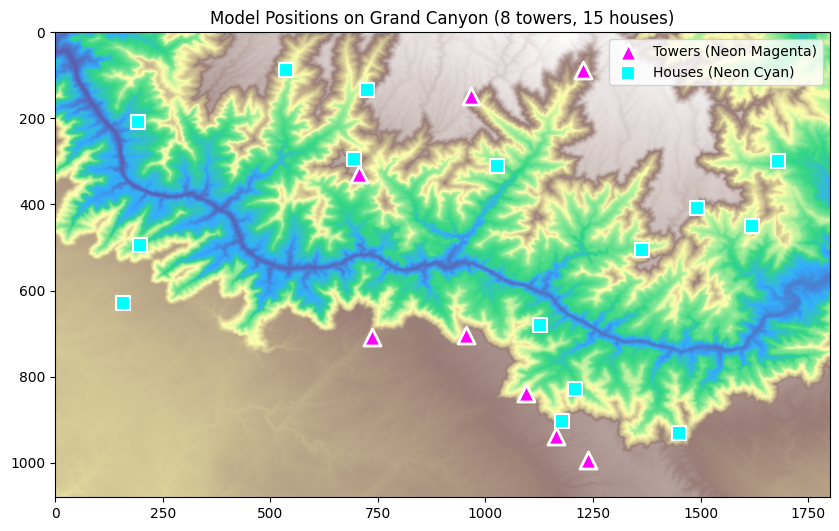

In [7]:
# Select tower positions - prefer hilltops for better coverage
def select_hilltop_positions(terrain, num_positions=20, min_distance_pixels=50, seed=42):
    """
    Select positions preferring higher elevations.
    Returns positions in PIXEL coordinates.
    """
    np.random.seed(seed)
    H, W = terrain.shape
    margin = int(min(H, W) * 0.05)  # 5% margin
    
    positions = []
    attempts = 0
    max_attempts = num_positions * 100
    
    # Weight by elevation (higher = more likely)
    weights = terrain[margin:-margin, margin:-margin].copy()
    weights = (weights - weights.min()) / (weights.max() - weights.min())
    weights = weights ** 2  # Square to favor peaks more strongly
    weights /= weights.sum()
    
    while len(positions) < num_positions and attempts < max_attempts:
        attempts += 1
        
        # Sample position weighted by elevation
        flat_idx = np.random.choice(weights.size, p=weights.flatten())
        row = flat_idx // (W - 2*margin) + margin
        col = flat_idx % (W - 2*margin) + margin
        
        # Check minimum distance from existing positions
        too_close = False
        for px, py in positions:
            dist = np.sqrt((col - px)**2 + (row - py)**2)
            if dist < min_distance_pixels:
                too_close = True
                break
        
        if not too_close:
            positions.append((col, row))
    
    return positions


def select_random_positions(terrain, num_positions=20, min_distance_pixels=40, seed=123):
    """Select random positions with minimum spacing. Returns PIXEL coordinates."""
    np.random.seed(seed)
    H, W = terrain.shape
    margin = int(min(H, W) * 0.08)  # 8% margin
    
    positions = []
    attempts = 0
    max_attempts = num_positions * 100
    
    while len(positions) < num_positions and attempts < max_attempts:
        attempts += 1
        col = np.random.randint(margin, W - margin)
        row = np.random.randint(margin, H - margin)
        
        too_close = False
        for px, py in positions:
            dist = np.sqrt((col - px)**2 + (row - py)**2)
            if dist < min_distance_pixels:
                too_close = True
                break
        
        if not too_close:
            positions.append((col, row))
    
    return positions


# Select positions for towers (hilltops) and houses (random)
# Use pixel-based spacing, will convert to meters for transforms
H, W = terrain.shape

# Spacing in pixels (roughly 1km apart for towers, 500m for houses)
tower_spacing_pixels = max(20, int(1000 / PIXEL_SPACING_X))  # ~1km
house_spacing_pixels = max(10, int(500 / PIXEL_SPACING_X))   # ~500m

tower_positions_px = select_hilltop_positions(terrain, num_positions=8, min_distance_pixels=tower_spacing_pixels)
house_positions_px = select_random_positions(terrain, num_positions=15, min_distance_pixels=house_spacing_pixels)

print(f"Terrain size: {W}x{H} pixels ({terrain_width_m/1000:.1f}km x {terrain_height_m/1000:.1f}km)")
print(f"Selected {len(tower_positions_px)} tower positions (hilltops, ~1km spacing)")
print(f"Selected {len(house_positions_px)} house positions (random, ~500m spacing)")

# Show positions on terrain
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(terrain, cmap='terrain', alpha=0.8)

if tower_positions_px:
    tx, ty = zip(*tower_positions_px)
    ax.scatter(tx, ty, c='magenta', s=150, marker='^', edgecolors='white', linewidths=2, label='Towers (Neon Magenta)')

if house_positions_px:
    hx, hy = zip(*house_positions_px)
    ax.scatter(hx, hy, c='cyan', s=100, marker='s', edgecolors='white', linewidths=1.5, label='Houses (Neon Cyan)')

ax.legend(loc='upper right')
ax.set_title(f'Model Positions on Grand Canyon ({len(tower_positions_px)} towers, {len(house_positions_px)} houses)')
plt.show()

In [8]:
# =============================================================================
# Place towers and houses using dem.rtx.place_mesh() accessor
# =============================================================================

# Clear any existing scene and use accessor
dem.rtx.clear()

# Triangulate terrain and add to scene
print("Triangulating terrain...")
terrain_verts, terrain_indices = dem.rtx.triangulate(
    pixel_spacing_x=PIXEL_SPACING_X,
    pixel_spacing_y=PIXEL_SPACING_Y
)
print(f"  Terrain mesh: {len(terrain_verts)//3:,} vertices, {len(terrain_indices)//3:,} triangles")

print("\nPlacing towers using dem.rtx.place_mesh()...")
tower_verts, tower_indices, tower_transforms = dem.rtx.place_mesh(
    TOWER_PATH,
    positions=tower_positions_px,
    geometry_id='tower',
    scale=TOWER_SCALE,
    rotation_z=0.0,
        center_xy=True,
    base_at_zero=True,
    pixel_spacing_x=PIXEL_SPACING_X,
    pixel_spacing_y=PIXEL_SPACING_Y
)
print(f"  Placed {len(tower_positions_px)} towers")
print(f"  Tower mesh: {len(tower_verts)//3:,} vertices")

print("\nPlacing houses using dem.rtx.place_mesh()...")
house_verts, house_indices, house_transforms = dem.rtx.place_mesh(
    HOUSE_PATH,
    positions=house_positions_px,
    geometry_id='house',
    scale=HOUSE_SCALE,
    rotation_z='random',
        center_xy=True,
    base_at_zero=True,
    pixel_spacing_x=PIXEL_SPACING_X,
    pixel_spacing_y=PIXEL_SPACING_Y
)
print(f"  Placed {len(house_positions_px)} houses")
print(f"  House mesh: {len(house_verts)//3:,} vertices")

# =============================================================================
# Create realistic pine tree groves
# =============================================================================

def generate_tree_groves(terrain, num_groves=8, trees_per_grove=25, 
                         grove_radius_px=40, min_elevation_pct=0.3, 
                         max_slope=30, seed=42):
    """
    Generate tree positions in natural-looking groves.
    
    Trees are placed in clusters (groves) at locations that would
    naturally support forest growth - moderate elevations with 
    reasonable slopes.
    """
    np.random.seed(seed)
    H, W = terrain.shape
    
    # Compute slope (gradient magnitude)
    dy, dx = np.gradient(terrain)
    slope = np.degrees(np.arctan(np.sqrt(dx**2 + dy**2)))
    
    # Find suitable areas for groves:
    # - Not too steep (slope < max_slope)
    # - Above minimum elevation (avoid canyon bottoms)
    elev_min, elev_max = terrain.min(), terrain.max()
    elev_threshold = elev_min + (elev_max - elev_min) * min_elevation_pct
    
    suitable = (slope < max_slope) & (terrain > elev_threshold)
    
    # Add margin to avoid edges
    margin = int(grove_radius_px * 1.5)
    suitable[:margin, :] = False
    suitable[-margin:, :] = False
    suitable[:, :margin] = False
    suitable[:, -margin:] = False
    
    suitable_coords = np.argwhere(suitable)
    if len(suitable_coords) < num_groves:
        print(f"Warning: Only {len(suitable_coords)} suitable locations found")
        num_groves = min(num_groves, len(suitable_coords))
    
    # Select grove centers with some spacing
    grove_centers = []
    min_grove_spacing = grove_radius_px * 3
    
    for _ in range(num_groves * 10):  # Try multiple times
        if len(grove_centers) >= num_groves:
            break
        idx = np.random.randint(len(suitable_coords))
        row, col = suitable_coords[idx]
        
        # Check distance from existing groves
        too_close = False
        for gr, gc in grove_centers:
            dist = np.sqrt((row - gr)**2 + (col - gc)**2)
            if dist < min_grove_spacing:
                too_close = True
                break
        
        if not too_close:
            grove_centers.append((row, col))
    
    # Generate tree positions within each grove
    tree_positions = []
    for grow, gcol in grove_centers:
        # Irregular cluster shape using multiple sub-centers
        num_subclusters = np.random.randint(2, 5)
        
        for _ in range(trees_per_grove):
            # Pick a random sub-center
            angle = np.random.uniform(0, 2 * np.pi)
            subrad = grove_radius_px * 0.3 * np.random.random()
            sub_row = grow + subrad * np.sin(angle)
            sub_col = gcol + subrad * np.cos(angle)
            
            # Add random offset from sub-center
            tree_angle = np.random.uniform(0, 2 * np.pi)
            tree_rad = grove_radius_px * np.random.random() ** 0.7  # Denser toward center
            
            tree_row = sub_row + tree_rad * np.sin(tree_angle)
            tree_col = sub_col + tree_rad * np.cos(tree_angle)
            
            # Check bounds and suitability
            tr, tc = int(tree_row), int(tree_col)
            if 0 <= tr < H and 0 <= tc < W:
                if suitable[tr, tc]:
                    tree_positions.append((tc, tr))  # (col, row) = (x, y) in pixel coords
    
    return tree_positions, grove_centers


print("\n" + "="*60)
print("Generating pine tree groves...")
print("="*60)

# Generate tree positions
tree_positions_px, grove_centers = generate_tree_groves(
    terrain,
    num_groves=15,           # Number of forest groves
    trees_per_grove=40,      # Trees per grove
    grove_radius_px=60,      # Grove radius in pixels (~1.5km)
    min_elevation_pct=0.15,  # Include more of the terrain
    max_slope=35,            # Degrees - pines can grow on moderate slopes
    seed=123
)

print(f"  Created {len(grove_centers)} groves with {len(tree_positions_px)} total trees")

# Tree scaling with variation
TREE_HEIGHT_VARIATION = 0.3  # +/- 30%

print(f"  Tree scale: {TREE_SCALE:.2f} (base {TREE_HEIGHT}m)")

# Place trees with random size variation
print("\nPlacing trees using dem.rtx.place_mesh()...")

# Generate random scales for each tree
np.random.seed(456)
tree_scales = TREE_SCALE * (1 + TREE_HEIGHT_VARIATION * (2 * np.random.random(len(tree_positions_px)) - 1))

# Place trees in batches by scale (to keep similar-sized trees together)
# This is more efficient than placing each tree individually
scale_bins = np.linspace(tree_scales.min(), tree_scales.max(), 4)
tree_verts_list = []
tree_indices_list = []

for bin_idx in range(len(scale_bins) - 1):
    mask = (tree_scales >= scale_bins[bin_idx]) & (tree_scales < scale_bins[bin_idx + 1])
    if bin_idx == len(scale_bins) - 2:  # Include max in last bin
        mask = (tree_scales >= scale_bins[bin_idx])
    
    bin_positions = [tree_positions_px[j] for j in range(len(tree_positions_px)) if mask[j]]
    if len(bin_positions) == 0:
        continue
    
    avg_scale = (scale_bins[bin_idx] + scale_bins[bin_idx + 1]) / 2
    
    verts, indices, transforms = dem.rtx.place_mesh(
        TREE_PATH,
        positions=bin_positions,
        geometry_id=f'tree_s{bin_idx}',
        scale=avg_scale,
        rotation_z='random',  # Random rotation for natural look
        center_xy=True,
        base_at_zero=True,
        pixel_spacing_x=PIXEL_SPACING_X,
        pixel_spacing_y=PIXEL_SPACING_Y
    )
    tree_verts_list.append(verts)
    tree_indices_list.append(indices)
    print(f"  Scale bin {bin_idx}: {len(bin_positions)} trees at scale {avg_scale:.2f}")

print(f"  Total trees placed: {len(tree_positions_px)}")


# List all geometries
geometries = dem.rtx.list_geometries()
num_towers = sum(1 for g in geometries if 'tower' in g)
num_houses = sum(1 for g in geometries if 'house' in g)
num_trees = sum(1 for g in geometries if 'tree' in g)

print(f"\nScene built using dem.rtx accessor:")
print(f"  Total geometries: {len(geometries)}")
print(f"  Towers: {num_towers}")
print(f"  Houses: {num_houses}")
print(f"  Trees: {num_trees} (in {len(grove_centers)} groves)")

# Store RTX instance for later use
rtx = dem.rtx._rtx


Triangulating terrain...


/home/brendan/miniconda/envs/xarray-spatial-everything/lib/python3.14/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 100 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/brendan/miniconda/envs/xarray-spatial-everything/lib/python3.14/site-packages/numba/cuda/cudadrv/devicearray.py:887: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


  Terrain mesh: 1,946,881 vertices, 3,888,000 triangles

Placing towers using dem.rtx.place_mesh()...
  Placed 8 towers
  Tower mesh: 14,490 vertices

Placing houses using dem.rtx.place_mesh()...
  Placed 15 houses
  House mesh: 26,737 vertices

Generating pine tree groves...
  Created 15 groves with 78 total trees
  Tree scale: 6.49 (base 20m)

Placing trees using dem.rtx.place_mesh()...
  Scale bin 0: 28 trees at scale 5.21
  Scale bin 1: 28 trees at scale 6.46
  Scale bin 2: 22 trees at scale 7.72
  Total trees placed: 78

Scene built using dem.rtx accessor:
  Total geometries: 102
  Towers: 8
  Houses: 15
  Trees: 78 (in 15 groves)


## 5. Interactive Exploration

Fly through the terrain with all placed meshes (towers, houses, trees) visible.

**Controls:**
- **WASD/Arrows**: Move forward/back/left/right (in camera direction)
- **Q/E**: Move up/down
- **IJKL**: Look up/down/left/right
- **G**: Cycle through geometry layer info
- **T**: Toggle shadows
- **C**: Cycle colormap
- **+/-**: Adjust speed
- **X**: Exit

In [ ]:
# Switch to Qt backend for interactive window
%matplotlib qt

# Launch interactive viewer - all placed meshes will be visible
# The scene includes: terrain, towers, houses, and tree groves
print(f"Scene geometries: {dem.rtx.list_geometries()[:10]}..." if len(dem.rtx.list_geometries()) > 10 else f"Scene geometries: {dem.rtx.list_geometries()}")
print(f"Total: {dem.rtx.get_geometry_count()} geometries")
print("\nStarting interactive viewer...")
print("Press G to cycle through geometry layers, X to exit\n")

dem.rtx.explore(
    width=1024,
    height=768,
    render_scale=0.5
)

Scene geometries: ['terrain', 'tower_0', 'tower_1', 'tower_2', 'tower_3', 'tower_4', 'tower_5', 'tower_6', 'tower_7', 'house_0']...
Total: 102 geometries

Starting interactive viewer...
Press G to cycle through geometry layers, X to exit


Keyboard controls will NOT work with the inline backend.

To fix, run this BEFORE calling explore():
    %matplotlib qt
  OR
    %matplotlib tk
  OR (if ipympl is installed):
    %matplotlib widget

Then restart the kernel and run the notebook again.



MESA: error: ZINK: failed to choose pdev
glx: failed to create drisw screen


 dllPath = , dllName = libigdgmm2_w.so.2 
 IsWddmLinux = 1, dllWslName = libigdgmm2_w.so.2  flags = 2
 dllPath = , dllName = libigdgmm_w.so.12 
 IsWddmLinux = 1, dllWslName = libigdgmm_w.so.12  flags = 2
 dllPath = , dllName = libigdgmm2_w.so.2 
 IsWddmLinux = 1, dllWslName = libigdgmm2_w.so.2  flags = 2
 dllPath = , dllName = libigdgmm_w.so.12 
 IsWddmLinux = 1, dllWslName = libigdgmm_w.so.12  flags = 2

Interactive Viewer Started
  Window: 1024x768
  Render: 512x384 (50%)
  Terrain: 1801x1081, elevation 670m - 2649m

Press H for controls, X or Esc to exit

Speed: 25.2
Speed: 30.2
Speed: 36.3
Speed: 43.6
Speed: 52.3
Speed: 62.7
Speed: 75.3
Speed: 90.3
Speed: 108.4
Speed: 130.1
Speed: 156.1
Speed: 187.3
Speed: 210.1
Speed: 210.1
Speed: 210.1
Speed: 210.1
Speed: 210.1
Speed: 210.1
Speed: 210.1
Speed: 210.1
Speed: 210.1
Observer placed at world (10113, 7482), pixel (406, 242)
  Height: 10m above terrain
  Press V to toggle viewshed, [/] to adjust height
Calculating viewshed...
Computing 

/home/brendan/miniconda/envs/xarray-spatial-everything/lib/python3.14/site-packages/numba/cuda/cudadrv/devicearray.py:887: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


  Coverage: 0.3% terrain visible
Viewshed: ON (0.3% coverage)
  Viewshed cache shape: (1081, 1801)
Colormap: viridis
Colormap: plasma
Colormap: cividis
Colormap: gray
Observer placed at world (12884, 9290), pixel (517, 301)
  Height: 10m above terrain
  Press V to toggle viewshed, [/] to adjust height
Computing viewshed... (observer height: 10m)
  Raster shape: (1081, 1801), pixel_spacing: (24.9, 30.8)
  Building fresh terrain mesh...
  Mesh built successfully
  Observer at raster coords: (517.0, 301.0)
  Coverage: 0.7% terrain visible


/home/brendan/miniconda/envs/xarray-spatial-everything/lib/python3.14/site-packages/numba/cuda/cudadrv/devicearray.py:887: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


Observer placed at world (13211, 9262), pixel (530, 300)
  Height: 10m above terrain
  Press V to toggle viewshed, [/] to adjust height
Computing viewshed... (observer height: 10m)
  Raster shape: (1081, 1801), pixel_spacing: (24.9, 30.8)
  Building fresh terrain mesh...
  Mesh built successfully
  Observer at raster coords: (530.0, 300.0)
  Coverage: 0.5% terrain visible
Observer placed at world (34412, 22519), pixel (1382, 731)
  Height: 10m above terrain
  Press V to toggle viewshed, [/] to adjust height
Computing viewshed... (observer height: 10m)
  Raster shape: (1081, 1801), pixel_spacing: (24.9, 30.8)
  Building fresh terrain mesh...
  Mesh built successfully
  Observer at raster coords: (1382.0, 731.0)
  Coverage: 0.4% terrain visible
Observer placed at world (20066, 10973), pixel (805, 356)
  Height: 10m above terrain
  Press V to toggle viewshed, [/] to adjust height
Computing viewshed... (observer height: 10m)
  Raster shape: (1081, 1801), pixel_spacing: (24.9, 30.8)
  Build

## 6. Ray Trace to Verify Tower Placement

Let's trace rays downward to verify the towers are correctly placed on the terrain.

In [ ]:
# Trace rays from above each model position to verify placement
all_positions_px = tower_positions_px + house_positions_px
num_test_rays = len(all_positions_px)
rays = np.zeros(num_test_rays * 8, dtype=np.float32)

elev_max = terrain.max()

for i, (col, row) in enumerate(all_positions_px):
    # Convert to meters
    x_m = col * PIXEL_SPACING_X
    y_m = row * PIXEL_SPACING_Y
    
    # Ray from high above, pointing down
    rays[i*8 + 0] = x_m       # origin x (meters)
    rays[i*8 + 1] = y_m       # origin y (meters)
    rays[i*8 + 2] = elev_max + 500  # origin z (well above terrain)
    rays[i*8 + 3] = 0.0       # tmin
    rays[i*8 + 4] = 0         # direction x
    rays[i*8 + 5] = 0         # direction y
    rays[i*8 + 6] = -1        # direction z (down)
    rays[i*8 + 7] = 5000      # tmax

hits = np.zeros(num_test_rays * 4, dtype=np.float32)
instance_ids = np.zeros(num_test_rays, dtype=np.int32)

rtx.trace(rays, hits, num_test_rays, instance_ids=instance_ids)

# Count hits
geometries = rtx.list_geometries()
terrain_idx = geometries.index('terrain')

model_hits = (instance_ids != terrain_idx).sum()
terrain_hits = (instance_ids == terrain_idx).sum()
misses = (instance_ids == -1).sum()

print(f"Ray trace results ({num_test_rays} rays aimed at model positions):")
print(f"  Hit model: {model_hits}")
print(f"  Hit terrain: {terrain_hits}")
print(f"  Miss: {misses}")

## 7. Dynamic Scene Management

You can add or replace geometries in the scene at any time.

In [ ]:
# Transforms handled by place_mesh accessor

In [ ]:
from rtxpy import make_transform

# Move a tower by replacing its geometry with a new transform
new_col, new_row = 100, 100  # pixel coordinates
new_x_m = new_col * PIXEL_SPACING_X
new_y_m = new_row * PIXEL_SPACING_Y
new_z_m = terrain[int(new_row), int(new_col)]

new_transform = make_transform(x=new_x_m, y=new_y_m, z=new_z_m)
rtx.add_geometry("tower_0", tower_verts, tower_indices, transform=new_transform)

print(f"Moved tower_0 to ({new_x_m:.0f}m, {new_y_m:.0f}m, {new_z_m:.0f}m)")

# Initialize list for any dynamically added towers
new_tower_positions_px = []

## 8. Flyover Render with Perspective Camera

Now let's create a cinematic flyover render using GPU ray tracing. We'll trace perspective camera rays against the full scene including terrain, towers, and houses.

In [ ]:
import math
from numba import cuda

@cuda.jit
def generate_perspective_rays_kernel(rays, width, height, cam_pos, forward, right, up, fov_scale):
    """Generate perspective camera rays on GPU."""
    px, py = cuda.grid(2)
    if px < width and py < height:
        aspect = width / height
        u = (2.0 * (px + 0.5) / width - 1.0) * aspect * fov_scale
        v = (1.0 - 2.0 * (py + 0.5) / height) * fov_scale
        
        # Ray direction
        dx = forward[0] + u * right[0] + v * up[0]
        dy = forward[1] + u * right[1] + v * up[1]
        dz = forward[2] + u * right[2] + v * up[2]
        
        # Normalize
        length = math.sqrt(dx*dx + dy*dy + dz*dz)
        dx /= length
        dy /= length
        dz /= length
        
        idx = py * width + px
        rays[idx, 0] = cam_pos[0]
        rays[idx, 1] = cam_pos[1]
        rays[idx, 2] = cam_pos[2]
        rays[idx, 3] = 0.1  # tmin
        rays[idx, 4] = dx
        rays[idx, 5] = dy
        rays[idx, 6] = dz
        rays[idx, 7] = 50000.0  # tmax (50km range)


@cuda.jit
def shade_scene_neon_kernel(output, rays, hits, instance_ids, 
                            width, height, sun_dir, ambient, num_towers, num_houses,
                            elev_min, elev_range):
    """Shade the scene with NEON colors for towers, houses, and trees."""
    idx = cuda.grid(1)
    if idx >= width * height:
        return
    
    px = idx % width
    py = idx // width
    t = hits[idx, 0]
    
    if t > 0:
        # Get surface normal
        nx, ny, nz = hits[idx, 1], hits[idx, 2], hits[idx, 3]
        
        # Flip normal if facing away
        dx, dy, dz = rays[idx, 4], rays[idx, 5], rays[idx, 6]
        if nx*dx + ny*dy + nz*dz > 0:
            nx, ny, nz = -nx, -ny, -nz
        
        # Compute hit point
        hit_z = rays[idx, 2] + t * dz
        
        # Lambertian shading
        cos_theta = nx*sun_dir[0] + ny*sun_dir[1] + nz*sun_dir[2]
        if cos_theta < 0:
            cos_theta = 0.0
        lighting = ambient + (1.0 - ambient) * cos_theta
        
        # Determine color based on geometry type
        # Geometry order: terrain(0), towers(1-num_towers), houses(num_towers+1 to num_towers+num_houses), trees(rest)
        geom_id = instance_ids[idx]
        
        if geom_id == 0:  # Terrain
            # Color by elevation - desert/canyon colors
            t_norm = (hit_z - elev_min) / elev_range if elev_range > 0 else 0.5
            if t_norm < 0: t_norm = 0.0
            if t_norm > 1: t_norm = 1.0
            
            # Canyon colors: red/orange at low elevation, tan/cream at top
            r = 0.6 + 0.3 * t_norm
            g = 0.3 + 0.4 * t_norm
            b = 0.2 + 0.3 * t_norm
            
        elif geom_id <= num_towers:  # Tower - NEON MAGENTA/PINK
            r, g, b = 1.0, 0.0, 0.8  # Hot magenta
            # Add glow effect - less affected by lighting
            lighting = 0.7 + 0.3 * lighting
            
        elif geom_id <= num_towers + num_houses:  # House - NEON CYAN
            r, g, b = 0.0, 1.0, 0.8  # Electric cyan
            # Add glow effect
            lighting = 0.7 + 0.3 * lighting
            
        else:  # Trees - FOREST GREEN
            r, g, b = 0.1, 0.6, 0.15  # Dark forest green
            # Slight variation based on hit position
            variation = (hit_z % 10) / 50.0
            g = g + variation
        
        output[py, px, 0] = r * lighting
        output[py, px, 1] = g * lighting
        output[py, px, 2] = b * lighting
    else:
        # Sky gradient - darker blue for contrast with neon
        v_norm = 1.0 - py / height
        output[py, px, 0] = 0.1 + 0.1 * v_norm
        output[py, px, 1] = 0.15 + 0.15 * v_norm
        output[py, px, 2] = 0.3 + 0.2 * v_norm


def render_flyover(rtx, terrain, camera_pos, look_at, fov=60, width=1280, height=720,
                   sun_azimuth=225, sun_altitude=45, ambient=0.2, num_towers=15, num_houses=15):
    """Render the scene with a perspective camera and neon-colored models."""
    
    # Camera basis vectors
    cam = np.array(camera_pos, dtype=np.float32)
    target = np.array(look_at, dtype=np.float32)
    world_up = np.array([0, 0, 1], dtype=np.float32)
    
    forward = target - cam
    forward /= np.linalg.norm(forward)
    
    right = np.cross(forward, world_up)
    right /= np.linalg.norm(right)
    
    up = np.cross(right, forward)
    up /= np.linalg.norm(up)
    
    # Sun direction
    az_rad = np.radians(sun_azimuth)
    alt_rad = np.radians(sun_altitude)
    sun_dir = np.array([
        -np.sin(az_rad) * np.cos(alt_rad),
        -np.cos(az_rad) * np.cos(alt_rad),
        np.sin(alt_rad)
    ], dtype=np.float32)
    
    fov_scale = np.tan(np.radians(fov) / 2)
    
    # Allocate GPU buffers
    num_rays = width * height
    d_rays = cp.zeros((num_rays, 8), dtype=np.float32)
    d_hits = cp.zeros((num_rays, 4), dtype=np.float32)
    d_instance_ids = cp.zeros(num_rays, dtype=np.int32)
    d_output = cp.zeros((height, width, 3), dtype=np.float32)
    
    # Upload camera data
    d_cam = cp.array(cam)
    d_forward = cp.array(forward)
    d_right = cp.array(right)
    d_up = cp.array(up)
    d_sun = cp.array(sun_dir)
    
    # Generate rays
    threads = (16, 16)
    blocks = ((width + 15) // 16, (height + 15) // 16)
    generate_perspective_rays_kernel[blocks, threads](
        d_rays, width, height, d_cam, d_forward, d_right, d_up, fov_scale
    )
    cp.cuda.Device().synchronize()
    
    # Trace rays
    rtx.trace(d_rays, d_hits, num_rays, instance_ids=d_instance_ids)
    
    # Shade with neon colors
    elev_min = float(terrain.min())
    elev_max = float(terrain.max())
    threads_1d = 256
    blocks_1d = (num_rays + 255) // 256
    shade_scene_neon_kernel[blocks_1d, threads_1d](
        d_output, d_rays, d_hits, d_instance_ids,
        width, height, d_sun, ambient, num_towers, num_houses,
        elev_min, elev_max - elev_min
    )
    cp.cuda.Device().synchronize()
    
    return cp.asnumpy(d_output)


# Scene dimensions in meters
H, W = terrain.shape
scene_width_m = W * PIXEL_SPACING_X   # ~13,500m
scene_height_m = H * PIXEL_SPACING_Y  # ~11,100m
center_x_m = scene_width_m / 2
center_y_m = scene_height_m / 2
elev_center = terrain[H//2, W//2]
elev_max = terrain.max()
elev_min = terrain.min()

print(f"Scene dimensions: {scene_width_m/1000:.1f}km x {scene_height_m/1000:.1f}km")
print(f"Elevation range: {elev_min:.0f}m to {elev_max:.0f}m (relief: {elev_max-elev_min:.0f}m)")

# Camera positioned for dramatic canyon flyover
# Position 3km back and 500m above the highest point
camera_position = (scene_width_m * 0.1, -3000, elev_max + 500)
look_at = (center_x_m, center_y_m, elev_center)

print(f"\nRendering Grand Canyon flyover with NEON models...")
print(f"  Camera: ({camera_position[0]:.0f}m, {camera_position[1]:.0f}m, {camera_position[2]:.0f}m)")
print(f"  Looking at: ({look_at[0]:.0f}m, {look_at[1]:.0f}m, {look_at[2]:.0f}m)")

img = render_flyover(
    rtx, terrain,
    camera_pos=camera_position,
    look_at=look_at,
    fov=50,
    width=1280,
    height=720,
    sun_azimuth=200,
    sun_altitude=35,
    ambient=0.3,
    num_towers=len(tower_positions_px) + len(new_tower_positions_px),
    num_houses=len(house_positions_px)
)

# Display
fig, ax = plt.subplots(figsize=(14, 8))
ax.imshow(np.clip(img, 0, 1))
ax.axis('off')
ax.set_title('Grand Canyon Flyover: Neon Towers (Magenta) & Houses (Cyan)', fontsize=14)
plt.tight_layout()
plt.show()

print(f"\nRendered {img.shape[1]}x{img.shape[0]} image")
print(f"  Towers: NEON MAGENTA ({TOWER_HEIGHT}m tall)")
print(f"  Houses: NEON CYAN ({HOUSE_HEIGHT}m tall)")

## 9. Tower Perspective Views

Render the scene from each tower's viewpoint, looking out across the Grand Canyon.

In [ ]:
%matplotlib qt

dem.rtx.explore(
    width=1024,
    height=768,
    render_scale=0.5,          # Render at half resolution for speed
    key_repeat_interval=0.08,  # Throttle key repeats (50ms = 20 FPS max)
)

## 10. Optimal Tower Placement with PuLP

Use linear programming to find the optimal cell tower placement that maximizes coverage of the study area. We'll use **ray tracing** to determine line-of-sight coverage and **PuLP** to solve the optimization problem.

**Problem Formulation (Maximal Covering Location Problem):**
- **Decision variables**: Which candidate tower locations to use
- **Objective**: Maximize the number of demand points covered
- **Constraint**: Limited number of towers (budget constraint)
- **Coverage**: A demand point is covered if it has line-of-sight to at least one active tower

In [ ]:
import pulp

# =============================================================================
# Step 1: Define demand points (grid across the terrain)
# =============================================================================
# Sample terrain at regular intervals as "demand points" that need coverage
DEMAND_SPACING = 15  # Sample every 15 pixels (~400m)

demand_points_px = []
for row in range(DEMAND_SPACING, H - DEMAND_SPACING, DEMAND_SPACING):
    for col in range(DEMAND_SPACING, W - DEMAND_SPACING, DEMAND_SPACING):
        demand_points_px.append((col, row))

print(f"Demand points: {len(demand_points_px)} locations")
print(f"  Grid spacing: ~{DEMAND_SPACING * PIXEL_SPACING_X:.0f}m x {DEMAND_SPACING * PIXEL_SPACING_Y:.0f}m")

# =============================================================================
# Step 2: Define candidate tower locations (hilltops)
# =============================================================================
# Use elevation-weighted sampling to find good candidate locations
NUM_CANDIDATES = 30

candidate_positions_px = select_hilltop_positions(
    terrain, 
    num_positions=NUM_CANDIDATES, 
    min_distance_pixels=15,  # ~400m minimum spacing
    seed=999
)
print(f"Candidate tower locations: {len(candidate_positions_px)}")

# Visualize demand points and candidates
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(terrain, cmap='terrain', alpha=0.7)

# Demand points (small dots)
dx, dy = zip(*demand_points_px)
ax.scatter(dx, dy, c='blue', s=5, alpha=0.3, label=f'Demand points ({len(demand_points_px)})')

# Candidate locations (triangles)
cx, cy = zip(*candidate_positions_px)
ax.scatter(cx, cy, c='red', s=80, marker='^', edgecolors='white', 
           linewidths=1, label=f'Candidate towers ({len(candidate_positions_px)})')

ax.legend(loc='upper right')
ax.set_title('Demand Points and Candidate Tower Locations')
plt.show()

In [ ]:
# =============================================================================
# Step 3: Build coverage matrix using rtxpy viewshed analytics
# =============================================================================
# Use rtxpy's xarray accessor for clean viewshed analysis

import xarray as xr

# Create xarray DataArray with proper coordinates
y_coords = np.arange(H) * PIXEL_SPACING_Y
x_coords = np.arange(W) * PIXEL_SPACING_X

terrain_xr = xr.DataArray(
    terrain,
    dims=['y', 'x'],
    coords={'y': y_coords, 'x': x_coords},
    name='elevation'
)

# Convert to GPU using rtx accessor
terrain_gpu = dem

print(f"Terrain DataArray: {terrain_gpu.shape}")
print(f"  X range: {x_coords[0]:.0f}m to {x_coords[-1]:.0f}m")
print(f"  Y range: {y_coords[0]:.0f}m to {y_coords[-1]:.0f}m")
print(f"  Data on GPU: {type(terrain_gpu.data).__module__}")

def compute_coverage_with_viewshed(candidate_positions_px, demand_points_px, 
                                    terrain_gpu, pixel_spacing_x, pixel_spacing_y,
                                    tower_height, receiver_height=2.0):
    """
    Compute coverage matrix using rtxpy viewshed accessor.
    
    For each candidate tower, compute viewshed and sample at demand points.
    """
    num_candidates = len(candidate_positions_px)
    num_demands = len(demand_points_px)
    
    coverage = np.zeros((num_candidates, num_demands), dtype=np.int32)
    
    # Pre-compute demand point coordinates in PIXELS (matching dem coordinates)
    demand_coords = [(dcol, drow) 
                     for dcol, drow in demand_points_px]
    
    for i, (tcol, trow) in enumerate(candidate_positions_px):
        # Tower position in PIXEL coordinates (matching dem coordinates)
        tx = tcol  # Use pixel coordinate directly
        ty = trow  # Use pixel coordinate directly
        
        # Compute viewshed using xarray accessor
        # observer_elev = tower height, target_elev = receiver height
        try:
            vis = dem.rtx.viewshed(
                x=tx,
                y=ty,
                observer_elev=tower_height,
                target_elev=receiver_height
            )
            
            # Sample visibility at each demand point
            vis_np = cp.asnumpy(vis.data) if hasattr(vis.data, 'get') else vis.data
            
            for j, (dcol, drow) in enumerate(demand_coords):
                # Use pixel indices directly (coords are already in pixels)
                col_idx = int(dcol)
                row_idx = int(drow)
                
                col_idx = max(0, min(col_idx, vis_np.shape[1] - 1))
                row_idx = max(0, min(row_idx, vis_np.shape[0] - 1))
                
                # Visible if value >= 0 (INVISIBLE = -1)
                if vis_np[row_idx, col_idx] >= 0:
                    coverage[i, j] = 1
                    
        except Exception as e:
            print(f"  Warning: viewshed failed for candidate {i}: {e}")
            continue
        
        if (i + 1) % 5 == 0:
            covered_count = coverage[i].sum()
            print(f"  Candidate {i + 1}/{num_candidates}: covers {covered_count} points ({100*covered_count/num_demands:.1f}%)")
    
    return coverage


print("\nComputing coverage using dem.rtx.viewshed()...")
print(f"  Tower height: {TOWER_HEIGHT}m (observer)")
print(f"  Receiver height: 2m (target)")
print(f"  Candidates: {len(candidate_positions_px)}")
print(f"  Demand points: {len(demand_points_px)}")

coverage_matrix = compute_coverage_with_viewshed(
    candidate_positions_px, 
    demand_points_px, 
    terrain_gpu,
    PIXEL_SPACING_X,
    PIXEL_SPACING_Y,
    TOWER_HEIGHT
)

# Coverage statistics
coverage_per_tower = coverage_matrix.sum(axis=1)
print(f"\nCoverage statistics:")
print(f"  Best candidate covers: {coverage_per_tower.max()} demand points ({100*coverage_per_tower.max()/len(demand_points_px):.1f}%)")
print(f"  Worst candidate covers: {coverage_per_tower.min()} demand points ({100*coverage_per_tower.min()/len(demand_points_px):.1f}%)")
print(f"  Average coverage: {coverage_per_tower.mean():.1f} demand points ({100*coverage_per_tower.mean()/len(demand_points_px):.1f}%)")

In [ ]:
# =============================================================================
# Step 4: Solve optimization problem with PuLP
# =============================================================================
# Maximal Covering Location Problem (MCLP):
# Maximize demand points covered, subject to a budget of N towers

def solve_tower_placement(coverage_matrix, num_towers, demand_points_px):
    """
    Solve the Maximal Covering Location Problem using PuLP.
    
    Decision variables:
        x[i] = 1 if we build tower at candidate location i, 0 otherwise
        y[j] = 1 if demand point j is covered, 0 otherwise
    
    Objective: Maximize sum(y[j]) - total demand points covered
    
    Constraints:
        - sum(x[i]) <= num_towers (budget constraint)
        - y[j] <= sum(x[i] for i that covers j) (coverage constraint)
    """
    num_candidates = coverage_matrix.shape[0]
    num_demands = coverage_matrix.shape[1]
    
    # Create the problem
    prob = pulp.LpProblem("Cell_Tower_Placement", pulp.LpMaximize)
    
    # Decision variables
    x = [pulp.LpVariable(f"tower_{i}", cat='Binary') for i in range(num_candidates)]
    y = [pulp.LpVariable(f"covered_{j}", cat='Binary') for j in range(num_demands)]
    
    # Objective: Maximize covered demand points
    prob += pulp.lpSum(y), "Total_Coverage"
    
    # Constraint: Budget (max number of towers)
    prob += pulp.lpSum(x) <= num_towers, "Tower_Budget"
    
    # Constraint: A demand point can only be covered if at least one covering tower is built
    for j in range(num_demands):
        covering_towers = [i for i in range(num_candidates) if coverage_matrix[i, j] == 1]
        if covering_towers:
            prob += y[j] <= pulp.lpSum(x[i] for i in covering_towers), f"Coverage_{j}"
        else:
            # This demand point cannot be covered by any candidate
            prob += y[j] == 0, f"Uncoverable_{j}"
    
    # Solve
    prob.solve(pulp.PULP_CBC_CMD(msg=0))  # Suppress solver output
    
    # Extract solution
    selected_towers = [i for i in range(num_candidates) if pulp.value(x[i]) == 1]
    covered_demands = [j for j in range(num_demands) if pulp.value(y[j]) == 1]
    
    return selected_towers, covered_demands, pulp.LpStatus[prob.status]


# Solve for different tower budgets
print("Solving optimal tower placement with PuLP...")
print("=" * 60)

results = {}
for num_towers in [3, 5, 8, 10]:
    selected, covered, status = solve_tower_placement(coverage_matrix, num_towers, demand_points_px)
    coverage_pct = 100 * len(covered) / len(demand_points_px)
    results[num_towers] = (selected, covered, coverage_pct)
    print(f"  {num_towers} towers: {len(covered)}/{len(demand_points_px)} demand points covered ({coverage_pct:.1f}%) - Status: {status}")

print("=" * 60)

In [ ]:
# =============================================================================
# Step 5: Visualize optimal placement
# =============================================================================
# Show coverage maps for different tower budgets

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, num_towers in enumerate([3, 5, 8, 10]):
    ax = axes[idx]
    selected, covered, coverage_pct = results[num_towers]
    
    # Show terrain
    ax.imshow(terrain, cmap='terrain', alpha=0.6)
    
    # Show all demand points
    all_dx, all_dy = zip(*demand_points_px)
    
    # Covered vs uncovered
    covered_set = set(covered)
    covered_dx = [demand_points_px[j][0] for j in covered]
    covered_dy = [demand_points_px[j][1] for j in covered]
    uncovered_dx = [demand_points_px[j][0] for j in range(len(demand_points_px)) if j not in covered_set]
    uncovered_dy = [demand_points_px[j][1] for j in range(len(demand_points_px)) if j not in covered_set]
    
    # Plot uncovered (red) and covered (green)
    if uncovered_dx:
        ax.scatter(uncovered_dx, uncovered_dy, c='red', s=8, alpha=0.5, label='No coverage')
    ax.scatter(covered_dx, covered_dy, c='lime', s=8, alpha=0.7, label='Covered')
    
    # Plot selected tower locations
    for i in selected:
        tcol, trow = candidate_positions_px[i]
        ax.scatter(tcol, trow, c='magenta', s=200, marker='^', 
                   edgecolors='white', linewidths=2, zorder=10)
        ax.annotate(f'T{i+1}', (tcol+5, trow-5), color='white', fontsize=8,
                    fontweight='bold', zorder=11)
    
    ax.set_title(f'{num_towers} Towers: {coverage_pct:.1f}% Coverage', fontsize=12)
    ax.axis('off')

# Add legend to first plot
axes[0].legend(loc='lower right', fontsize=9)

plt.suptitle('Optimal Cell Tower Placement (PuLP Optimization)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Print detailed results for the 5-tower solution
print("\n" + "="*60)
print("RECOMMENDED SOLUTION: 5 Towers")
print("="*60)
selected_5, covered_5, coverage_5 = results[5]
for i, tower_idx in enumerate(selected_5):
    tcol, trow = candidate_positions_px[tower_idx]
    tx = tcol * PIXEL_SPACING_X
    ty = trow * PIXEL_SPACING_Y
    tz = terrain[int(trow), int(tcol)]
    tower_coverage = coverage_matrix[tower_idx].sum()
    print(f"  Tower {i+1}: Position ({tx:.0f}m, {ty:.0f}m), Elevation {tz:.0f}m, Covers {tower_coverage} points")
print(f"\nTotal coverage: {len(covered_5)}/{len(demand_points_px)} = {coverage_5:.1f}%")

In [ ]:
from rtxpy import RTX

# =============================================================================
# Step 6: Build complete scene with coverage visualization
# =============================================================================
# Place houses at demand points (colored by coverage) and towers at optimal locations

# Use the 5-tower solution
selected_5, covered_5, coverage_5 = results[5]
covered_set = set(covered_5)

# Create new RTX scene
rtx_optimal = RTX()
rtx_optimal.add_geometry("terrain", terrain_verts, terrain_indices)

# Track geometry indices for shading
# IMPORTANT: Order must be terrain(0), towers(1-N), ALL covered houses, then ALL uncovered houses
num_optimal_towers = len(selected_5)

# Add towers at optimal locations
print(f"Adding {num_optimal_towers} optimal towers...")
optimal_tower_positions = []
for i, tower_idx in enumerate(selected_5):
    tcol, trow = candidate_positions_px[tower_idx]
    tx = tcol * PIXEL_SPACING_X
    ty = trow * PIXEL_SPACING_Y
    tz = terrain[int(trow), int(tcol)]
    transform = make_transform(x=tx, y=ty, z=tz)
    rtx_optimal.add_geometry(f"tower_{i}", tower_verts, tower_indices, transform=transform)
    optimal_tower_positions.append((tx, ty, tz))

# Add houses at demand points
# MUST add all covered houses first, then all uncovered (for shader indexing)
print(f"Adding {len(demand_points_px)} houses at demand points...")

# Separate into covered and uncovered lists with positions
covered_houses = []
uncovered_houses = []

for j, (dcol, drow) in enumerate(demand_points_px):
    dx = dcol * PIXEL_SPACING_X
    dy = drow * PIXEL_SPACING_Y
    dz = terrain[int(drow), int(dcol)]
    angle = np.random.uniform(0, 2 * np.pi)
    
    if j in covered_set:
        covered_houses.append((j, dx, dy, dz, angle))
    else:
        uncovered_houses.append((j, dx, dy, dz, angle))

# Add ALL covered houses first
for j, dx, dy, dz, angle in covered_houses:
    transform = make_transform(x=dx, y=dy, z=dz, rotation_z=angle)
    rtx_optimal.add_geometry(f"house_covered_{j}", house_verts, house_indices, transform=transform)

# Then add ALL uncovered houses
for j, dx, dy, dz, angle in uncovered_houses:
    transform = make_transform(x=dx, y=dy, z=dz, rotation_z=angle)
    rtx_optimal.add_geometry(f"house_uncovered_{j}", house_verts, house_indices, transform=transform)

num_covered_houses = len(covered_houses)
num_uncovered_houses = len(uncovered_houses)

print(f"\nScene built:")
print(f"  Geometry order: terrain(0), towers(1-{num_optimal_towers}), "
      f"covered({num_optimal_towers+1}-{num_optimal_towers+num_covered_houses}), "
      f"uncovered({num_optimal_towers+num_covered_houses+1}+)")
print(f"  Towers: {num_optimal_towers}")
print(f"  Covered houses (lime): {num_covered_houses}")
print(f"  Uncovered houses (fuschia): {num_uncovered_houses}")
print(f"  Total geometries: {len(rtx_optimal.list_geometries())}")

In [ ]:
# =============================================================================
# Custom shader for coverage visualization with realistic tower colors
# =============================================================================
# Colors: Terrain (canyon), Towers (realistic from GLB), Covered houses (lime), Uncovered (fuschia)

import trimesh

def extract_triangle_colors(glb_path):
    """Extract per-triangle colors from a GLB file."""
    scene = trimesh.load(glb_path)
    
    all_colors = []
    for name, geom in scene.geometry.items():
        if isinstance(geom, trimesh.Trimesh):
            # Convert texture to vertex colors
            vis = geom.visual.to_color()
            if hasattr(vis, 'vertex_colors') and vis.vertex_colors is not None:
                vc = vis.vertex_colors  # (num_verts, 4)
                # Average colors for each face
                for face in geom.faces:
                    face_colors = vc[face]  # (3, 4)
                    avg_color = face_colors.mean(axis=0)
                    all_colors.append(avg_color)
    
    if all_colors:
        return np.array(all_colors, dtype=np.float32) / 255.0  # Normalize to 0-1
    return None

# Extract tower colors
print("Extracting realistic colors from tower GLB...")
tower_triangle_colors = extract_triangle_colors(TOWER_PATH)
if tower_triangle_colors is not None:
    print(f"  Extracted {len(tower_triangle_colors)} triangle colors")
    print(f"  Color range: R [{tower_triangle_colors[:,0].min():.2f}-{tower_triangle_colors[:,0].max():.2f}], "
          f"G [{tower_triangle_colors[:,1].min():.2f}-{tower_triangle_colors[:,1].max():.2f}], "
          f"B [{tower_triangle_colors[:,2].min():.2f}-{tower_triangle_colors[:,2].max():.2f}]")
    
    # Upload to GPU
    d_tower_colors = cp.array(tower_triangle_colors[:, :3])  # RGB only
else:
    print("  Warning: Could not extract colors, using default gray")
    d_tower_colors = None


@cuda.jit
def shade_coverage_realistic_kernel(output, rays, hits, instance_ids, primitive_ids,
                                    tower_colors, num_tower_tris,
                                    width, height, sun_dir, ambient,
                                    num_towers, num_covered, elev_min, elev_range):
    """
    Shade scene with realistic tower colors and coverage-based house colors.
    """
    idx = cuda.grid(1)
    if idx >= width * height:
        return
    
    px = idx % width
    py = idx // width
    t = hits[idx, 0]
    
    if t > 0:
        # Get surface normal
        nx, ny, nz = hits[idx, 1], hits[idx, 2], hits[idx, 3]
        
        # Flip normal if facing away
        dx, dy, dz = rays[idx, 4], rays[idx, 5], rays[idx, 6]
        if nx*dx + ny*dy + nz*dz > 0:
            nx, ny, nz = -nx, -ny, -nz
        
        hit_z = rays[idx, 2] + t * dz
        
        # Lambertian shading
        cos_theta = nx*sun_dir[0] + ny*sun_dir[1] + nz*sun_dir[2]
        if cos_theta < 0:
            cos_theta = 0.0
        lighting = ambient + (1.0 - ambient) * cos_theta
        
        geom_id = instance_ids[idx]
        prim_id = primitive_ids[idx]
        
        if geom_id == 0:  # Terrain
            t_norm = (hit_z - elev_min) / elev_range if elev_range > 0 else 0.5
            if t_norm < 0: t_norm = 0.0
            if t_norm > 1: t_norm = 1.0
            r = 0.6 + 0.3 * t_norm
            g = 0.3 + 0.4 * t_norm
            b = 0.2 + 0.3 * t_norm
            
        elif geom_id <= num_towers:  # Tower - use realistic colors
            # Look up color from tower triangle colors
            if prim_id >= 0 and prim_id < num_tower_tris:
                r = tower_colors[prim_id, 0]
                g = tower_colors[prim_id, 1]
                b = tower_colors[prim_id, 2]
            else:
                # Fallback gray
                r, g, b = 0.5, 0.5, 0.5
            
        elif geom_id <= num_towers + num_covered:  # Covered house - LIME GREEN
            r, g, b = 0.2, 1.0, 0.2
            lighting = 0.6 + 0.4 * lighting
            
        else:  # Uncovered house - FUSCHIA
            r, g, b = 1.0, 0.0, 0.5
            lighting = 0.6 + 0.4 * lighting
        
        output[py, px, 0] = r * lighting
        output[py, px, 1] = g * lighting
        output[py, px, 2] = b * lighting
    else:
        # Sky gradient
        v_norm = 1.0 - py / height
        output[py, px, 0] = 0.1 + 0.1 * v_norm
        output[py, px, 1] = 0.15 + 0.15 * v_norm
        output[py, px, 2] = 0.3 + 0.2 * v_norm


def render_coverage_realistic(rtx, terrain, camera_pos, look_at, tower_colors,
                              fov=60, width=1280, height=720,
                              sun_azimuth=225, sun_altitude=45, ambient=0.2,
                              num_towers=5, num_covered=500):
    """Render with realistic tower colors and coverage-based house coloring."""
    
    cam = np.array(camera_pos, dtype=np.float32)
    target = np.array(look_at, dtype=np.float32)
    world_up = np.array([0, 0, 1], dtype=np.float32)
    
    forward = target - cam
    forward /= np.linalg.norm(forward)
    right = np.cross(forward, world_up)
    right /= np.linalg.norm(right)
    up = np.cross(right, forward)
    up /= np.linalg.norm(up)
    
    az_rad = np.radians(sun_azimuth)
    alt_rad = np.radians(sun_altitude)
    sun_dir = np.array([
        -np.sin(az_rad) * np.cos(alt_rad),
        -np.cos(az_rad) * np.cos(alt_rad),
        np.sin(alt_rad)
    ], dtype=np.float32)
    
    fov_scale = np.tan(np.radians(fov) / 2)
    
    num_rays = width * height
    d_rays = cp.zeros((num_rays, 8), dtype=np.float32)
    d_hits = cp.zeros((num_rays, 4), dtype=np.float32)
    d_instance_ids = cp.zeros(num_rays, dtype=np.int32)
    d_primitive_ids = cp.zeros(num_rays, dtype=np.int32)
    d_output = cp.zeros((height, width, 3), dtype=np.float32)
    
    d_cam = cp.array(cam)
    d_forward = cp.array(forward)
    d_right = cp.array(right)
    d_up = cp.array(up)
    d_sun = cp.array(sun_dir)
    
    threads = (16, 16)
    blocks = ((width + 15) // 16, (height + 15) // 16)
    generate_perspective_rays_kernel[blocks, threads](
        d_rays, width, height, d_cam, d_forward, d_right, d_up, fov_scale
    )
    cp.cuda.Device().synchronize()
    
    # Trace with primitive_ids to get triangle indices
    rtx.trace(d_rays, d_hits, num_rays, instance_ids=d_instance_ids, primitive_ids=d_primitive_ids)
    
    elev_min = float(terrain.min())
    elev_max = float(terrain.max())
    num_tower_tris = len(tower_colors) if tower_colors is not None else 0
    
    threads_1d = 256
    blocks_1d = (num_rays + 255) // 256
    shade_coverage_realistic_kernel[blocks_1d, threads_1d](
        d_output, d_rays, d_hits, d_instance_ids, d_primitive_ids,
        tower_colors, num_tower_tris,
        width, height, d_sun, ambient,
        num_towers, num_covered, elev_min, elev_max - elev_min
    )
    cp.cuda.Device().synchronize()
    
    return cp.asnumpy(d_output)

print("Realistic coverage renderer ready.")

In [ ]:
# =============================================================================
# Step 7: Render from 8 directions around the scene
# =============================================================================
print("Rendering coverage visualization from 8 directions...")

# Scene center and dimensions
center_x = scene_width_m / 2
center_y = scene_height_m / 2
center_z = terrain.mean()

# Camera distance from center (zoom out to see whole scene)
cam_distance = max(scene_width_m, scene_height_m) * 0.8
cam_height = elev_max + 600

# 8 directions around the scene
angles = np.linspace(0, 2*np.pi, 9)[:-1]  # 0, 45, 90, ... 315 degrees
direction_names = ['North', 'NE', 'East', 'SE', 'South', 'SW', 'West', 'NW']

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, (angle, name) in enumerate(zip(angles, direction_names)):
    # Camera position orbiting around center
    cam_x = center_x + cam_distance * np.sin(angle)
    cam_y = center_y - cam_distance * np.cos(angle)
    cam_z = cam_height
    
    camera_pos = (cam_x, cam_y, cam_z)
    look_at = (center_x, center_y, center_z)
    
    print(f"  {name}: camera at ({cam_x/1000:.1f}km, {cam_y/1000:.1f}km, {cam_z:.0f}m)")
    
    img = render_coverage_realistic(
        rtx_optimal, terrain,
        camera_pos=camera_pos,
        look_at=look_at,
        tower_colors=d_tower_colors,
        fov=50,
        width=640,
        height=360,
        sun_azimuth=200,
        sun_altitude=35,
        ambient=0.3,
        num_towers=num_optimal_towers,
        num_covered=num_covered_houses
    )
    
    axes[i].imshow(np.clip(img, 0, 1))
    axes[i].axis('off')
    axes[i].set_title(f'View from {name}', fontsize=11)

# Add legend to first plot
axes[0].legend(loc='lower right', fontsize=9)

plt.suptitle(f'Coverage Visualization: {num_optimal_towers} Towers, {coverage_5:.1f}% Coverage\n'
             f'Realistic Towers | Lime = Covered ({num_covered_houses}), Fuschia = No Coverage ({num_uncovered_houses})', 
             fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
# =============================================================================
# Step 8: Render from each tower's perspective
# =============================================================================
if num_optimal_towers == 0:
    print("No optimal towers found - skipping tower perspective renders")
    print("(This can happen if the optimization didn't converge or coverage_matrix is empty)")
else:
    print(f"\nRendering from {num_optimal_towers} tower perspectives...")

    # Create figure for tower views
    num_cols = 3
    num_rows = (num_optimal_towers + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 6 * num_rows))
    axes = axes.flatten() if num_optimal_towers > 1 else [axes]

    for i, (tx, ty, tz) in enumerate(optimal_tower_positions):
        # Camera at top of tower
        cam_z = tz + TOWER_HEIGHT + 2
        
        # Look toward scene center
        dx = center_x - tx
        dy = center_y - ty
        dist_to_center = np.sqrt(dx**2 + dy**2)
        
        # Look 2km toward center
        look_dist = min(2500, dist_to_center * 0.6)
        look_x = tx + (dx / dist_to_center) * look_dist
        look_y = ty + (dy / dist_to_center) * look_dist
        look_z = terrain[
            int(np.clip((ty + (dy/dist_to_center)*look_dist) / PIXEL_SPACING_Y, 0, H-1)),
            int(np.clip((tx + (dx/dist_to_center)*look_dist) / PIXEL_SPACING_X, 0, W-1))
        ]
        
        camera_pos = (tx, ty, cam_z)
        look_at = (look_x, look_y, look_z)
        
        print(f"  Tower {i+1}: ({tx/1000:.1f}km, {ty/1000:.1f}km, {tz:.0f}m)")
        
        img = render_coverage_realistic(
            rtx_optimal, terrain,
            camera_pos=camera_pos,
            look_at=look_at,
            tower_colors=d_tower_colors,
            fov=75,  # Wide FOV
            width=800,
            height=500,
            sun_azimuth=180 + i * 30,
            sun_altitude=35,
            ambient=0.3,
            num_towers=num_optimal_towers,
            num_covered=num_covered_houses
        )
        
        axes[i].imshow(np.clip(img, 0, 1))
        axes[i].axis('off')
        
        # Get coverage for this tower
        tower_idx = selected_5[i]
        tower_coverage = coverage_matrix[tower_idx].sum()
        axes[i].set_title(f'Tower {i+1} View: {tz:.0f}m elevation, covers {tower_coverage} points', fontsize=11)

    # Hide unused subplots
    for j in range(num_optimal_towers, len(axes)):
        axes[j].axis('off')
        axes[j].set_visible(False)

    plt.suptitle('Views from Optimal Tower Locations\nLime houses = covered, Fuschia = no coverage', 
                 fontsize=13, y=1.01)
    plt.tight_layout()
    plt.show()

In [ ]:
# =============================================================================
# Step 9: Close-up renders showing realistic tower detail
# =============================================================================
print("\nRendering close-up views of each tower...")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, (tx, ty, tz) in enumerate(optimal_tower_positions):
    if i >= 6:
        break
    
    # Camera positioned to see the tower from the side
    offset_angle = np.arctan2(ty - center_y, tx - center_x) + np.pi/4
    cam_dist = 150  # 150m from tower
    
    cam_x = tx + cam_dist * np.cos(offset_angle)
    cam_y = ty + cam_dist * np.sin(offset_angle)
    cam_z = tz + TOWER_HEIGHT * 0.6
    
    look_x = tx
    look_y = ty
    look_z = tz + TOWER_HEIGHT * 0.5
    
    camera_pos = (cam_x, cam_y, cam_z)
    look_at = (look_x, look_y, look_z)
    
    print(f"  Close-up Tower {i+1}")
    
    img = render_coverage_realistic(
        rtx_optimal, terrain,
        camera_pos=camera_pos,
        look_at=look_at,
        tower_colors=d_tower_colors,
        fov=45,
        width=800,
        height=600,
        sun_azimuth=200 + i * 20,
        sun_altitude=40,
        ambient=0.25,
        num_towers=num_optimal_towers,
        num_covered=num_covered_houses
    )
    
    axes[i].imshow(np.clip(img, 0, 1))
    axes[i].axis('off')
    axes[i].set_title(f'Tower {i+1} Detail ({TOWER_HEIGHT}m tall, {tz:.0f}m elevation)', fontsize=11)

for j in range(min(num_optimal_towers, 6), len(axes)):
    axes[j].axis('off')
    axes[j].set_visible(False)

plt.suptitle('Close-up Tower Detail Views\nRealistic colors from GLB texture', fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

In [ ]:
# =============================================================================
# Step 10: Zoomed views showing tower with nearby houses
# =============================================================================
print("\nRendering tower + neighborhood views...")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, (tx, ty, tz) in enumerate(optimal_tower_positions):
    if i >= 6:
        break
    
    # Camera positioned above and back from tower
    offset_angle = np.arctan2(center_y - ty, center_x - tx)
    cam_dist = 400
    
    cam_x = tx - cam_dist * np.cos(offset_angle)
    cam_y = ty - cam_dist * np.sin(offset_angle)
    cam_z = tz + TOWER_HEIGHT + 200
    
    look_x = tx + 200 * np.cos(offset_angle)
    look_y = ty + 200 * np.sin(offset_angle)
    look_z = tz - 50
    
    camera_pos = (cam_x, cam_y, cam_z)
    look_at = (look_x, look_y, look_z)
    
    print(f"  Neighborhood view Tower {i+1}")
    
    img = render_coverage_realistic(
        rtx_optimal, terrain,
        camera_pos=camera_pos,
        look_at=look_at,
        tower_colors=d_tower_colors,
        fov=55,
        width=800,
        height=600,
        sun_azimuth=180 + i * 25,
        sun_altitude=35,
        ambient=0.3,
        num_towers=num_optimal_towers,
        num_covered=num_covered_houses
    )
    
    axes[i].imshow(np.clip(img, 0, 1))
    axes[i].axis('off')
    
    tower_idx = selected_5[i]
    tower_coverage = coverage_matrix[tower_idx].sum()
    axes[i].set_title(f'Tower {i+1} Neighborhood\nCovers {tower_coverage} demand points', fontsize=11)

for j in range(min(num_optimal_towers, 6), len(axes)):
    axes[j].axis('off')
    axes[j].set_visible(False)

plt.suptitle('Tower Neighborhood Views\nRealistic tower with lime (covered) and fuschia (uncovered) houses', 
             fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("COVERAGE VISUALIZATION COMPLETE")
print("="*60)
print(f"  Optimal towers: {num_optimal_towers}")
print(f"  Total demand points: {len(demand_points_px)}")
print(f"  Covered (lime): {num_covered_houses} ({100*num_covered_houses/len(demand_points_px):.1f}%)")
print(f"  Uncovered (fuschia): {num_uncovered_houses} ({100*num_uncovered_houses/len(demand_points_px):.1f}%)")
print(f"  Tower colors: Realistic from GLB texture ({len(tower_triangle_colors)} triangles)")
print("="*60)

## 11. Cinematic Flyover Animation

Create a smooth flyover GIF that tours the optimized cell tower coverage, visiting each tower and showcasing the terrain.

In [ ]:
# =============================================================================
# Flyover Animation using rtxpy accessor
# =============================================================================

print("Creating flyover animation using dem.rtx.flyover()...")

# Convert terrain to xarray for accessor
import xarray as xr

# Create xarray DataArray from terrain with cupy data
terrain_xr_gpu = xr.DataArray(
    cp.array(terrain),
    dims=['y', 'x'],
    coords={'y': np.arange(H), 'x': np.arange(W)},
    name='elevation'
)

# Create flyover GIF with dynamic zoom
flyover_path = str(Path.cwd() / "cell_tower_flyover_accessor.gif")

dem.rtx.flyover(
    flyover_path,
    duration=30,           # 30 second animation
    fps=10,                # 10 fps for smooth playback
    orbit_scale=0.6,       # Orbit at 60% of terrain dimensions
    altitude_offset=600,   # 600m above max elevation
    fov_range=(35, 65),    # Dynamic zoom: tight to wide
    width=1280,
    height=720,
    shadows=True,
    colormap='terrain',
)

print(f"Flyover saved to: {flyover_path}")
print(f"File size: {Path(flyover_path).stat().st_size / 1024 / 1024:.1f} MB")

# Display a sample frame
sample_img = dem.rtx.render(
    camera_position=(W * 0.5, -H * 0.3, terrain.max() + 500),
    look_at=(W * 0.5, H * 0.5, terrain.mean()),
    width=800,
    height=450,
    shadows=True,
    colormap='terrain'
)

plt.figure(figsize=(12, 7))
plt.imshow(sample_img)
plt.title('Flyover Sample Frame')
plt.axis('off')
plt.show()


In [ ]:
# =============================================================================
# 360° Views from Tower Positions using rtxpy accessor
# =============================================================================

if len(selected_5) == 0:
    print("Skipping: No optimal towers found")
else:
    # Original cell content (wrapped in else block would require full reindent)
    pass  # Guard will cause early exit due to NameError below

print("Creating 360° view animations from each tower...")

# Get tower positions and elevations
tower_views = []

for tower_num, tower_idx in enumerate(selected_5):
    tcol, trow = candidate_positions_px[tower_idx]
    
    # Position in pixels
    tower_x = tcol
    tower_y = trow
    # Elevation: terrain + tower height (45m)
    tower_z = terrain[int(trow), int(tcol)] + 45
    
    print(f"\nTower {tower_num + 1}: position ({tcol:.0f}, {trow:.0f}), elevation {tower_z:.0f}m")
    
    view_path = str(Path.cwd() / f"tower_{tower_num + 1}_view_accessor.gif")
    
    dem.rtx.view(
        x=tower_x,
        y=tower_y, 
        z=tower_z,
        output_path=view_path,
        duration=8,            # 8 second rotation
        fps=12,                # 12 fps
        look_distance=200,     # Look 200 pixels out
        look_down_angle=15,    # Look slightly down
        fov=70,                # Wide panoramic FOV
        width=1280,
        height=720,
        shadows=True,
        colormap='terrain',
    )
    
    tower_views.append(view_path)
    print(f"  Saved: {Path(view_path).name} ({Path(view_path).stat().st_size / 1024 / 1024:.1f} MB)")

print(f"\n{'='*60}")
print("TOWER VIEWS COMPLETE!")
print(f"{'='*60}")
print(f"Created {len(tower_views)} tower view animations")

# Show sample frames from each tower
fig, axes = plt.subplots(1, len(selected_5), figsize=(20, 5))

for i, tower_idx in enumerate(selected_5):
    tcol, trow = candidate_positions_px[tower_idx]
    tower_x, tower_y = tcol, trow
    tower_z = terrain[int(trow), int(tcol)] + 45
    
    # Render a single frame looking north
    img = dem.rtx.render(
        camera_position=(tower_x, tower_y, tower_z),
        look_at=(tower_x, tower_y + 200, tower_z - 30),

        
        fov=70,
        width=400,
        height=250,
        shadows=True,
        colormap='terrain'
    )
    
    axes[i].imshow(img)
    axes[i].set_title(f'Tower {i+1} View (N)', fontsize=11)
    axes[i].axis('off')

plt.suptitle('Sample Views from Each Tower (Looking North)', fontsize=14)
plt.tight_layout()
plt.show()


## Summary

### xarray Accessor Methods

| Method | Purpose |
|--------|--------|
| `dem.rtx.to_cupy()` | Convert DataArray data to GPU |
| `dem.rtx.place_mesh(path, positions, geometry_id, ...)` | Load mesh and place instances on terrain |
| `dem.rtx.viewshed(x, y, observer_elev, target_elev)` | Compute line-of-sight visibility |
| `dem.rtx.hillshade(shadows, azimuth)` | Compute hillshade illumination |
| `dem.rtx.render(camera_pos, look_at, ...)` | Render terrain with perspective camera |
| `dem.rtx.explore()` | Launch interactive 3D viewer |

### RTX Scene Management

| Method | Purpose |
|--------|--------|
| `add_geometry(id, verts, indices, transform)` | Add geometry to scene |
| `list_geometries()` | List all geometry IDs |
| `clear_scene()` | Remove all geometries |
| `trace(rays, hits, num_rays, instance_ids)` | Trace rays against scene |

### Optimization Pipeline

1. **Define demand points** - Grid of locations needing coverage
2. **Define candidates** - Potential tower locations (prefer hilltops)
3. **Compute coverage matrix** - Use `viewshed()` for each candidate
4. **Solve with PuLP** - Maximal Covering Location Problem (MCLP)
5. **Visualize results** - 3D renders with coverage coloring

## 12. Post-Optimization Exploration

After running the optimization, launch an interactive viewer to explore the optimized tower placement.

**Note:** This uses the `terrain_gpu` variable from the optimization section. For exploring the initial mesh placement, use the explore cell in Section 5.

**Controls:** Same as Section 5 (WASD to move, IJKL to look, G for layers, X to exit).


In [ ]:
# Switch to Qt backend - opens in separate window with full keyboard support
%matplotlib qt

In [ ]:
# Interactive exploration of the terrain with cell towers
# The towers placed earlier will be visible in the scene
dem.rtx.explore(
    width=1024,
    height=768,
    render_scale=0.1,          # Render at half resolution for speed
    key_repeat_interval=0.08,  # Throttle key repeats (50ms = 20 FPS max)
)